# Destination Recommender

## Library

In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import backend as K
from keras.models import model_from_json

from numpy import argmax

In [2]:
#pip install scikeras

## Data Preparation

### Read Data

In [3]:
dataframe = pd.read_csv('newdata.csv', encoding='latin-1', index_col = None)

In [4]:
dataframe.head(5)

,Booking_Date,FakeName,FakeMail,Orig_Airport,Dest_Airport
0,2021-01-01,X0,M0,MPL,BGO
1,2021-01-01,X1,M1,MRS,CFR
2,2021-01-01,X2,M2,ORY,PTP
3,2021-01-01,X3,M3,MAN,AMS
4,2021-01-01,X4,M1,MUC,AMS


In [5]:
dataframe.shape

(315687, 5)

In [6]:
# change the column names:
dataframe = dataframe.rename(columns={'FakeName': 'FullNm', 'FakeMail': 'Email_Address'})

In [7]:
# Maximum and minimum date:
dataframe['Booking_Date'].agg(['min', 'max'])

min    2021-01-01
max    2022-12-28
Name: Booking_Date, dtype: object

In [8]:
dataframe.head(10)

,Booking_Date,FullNm,Email_Address,Orig_Airport,Dest_Airport
0,2021-01-01,X0,M0,MPL,BGO
1,2021-01-01,X1,M1,MRS,CFR
2,2021-01-01,X2,M2,ORY,PTP
3,2021-01-01,X3,M3,MAN,AMS
4,2021-01-01,X4,M1,MUC,AMS
5,2021-01-01,X5,M4,LHR,YYZ
6,2021-01-01,X6,M4,CPH,AUA
7,2021-01-01,X7,M1,ORY,PGF
8,2021-01-01,X8,M4,CDG,TLS
9,2021-01-01,X9,M4,CDG,NTE


### Filter Data:

#### Select the date only for 2022

In [9]:
dataframe = dataframe[dataframe.Booking_Date >= '2022-01-01']

#### Select people who have more than 100 flight

In [10]:
dataframe['FullNm_count'] = dataframe.groupby('FullNm')['FullNm'].transform('count')

In [11]:
dataframe = dataframe[dataframe.FullNm_count >= 100]

In [12]:
dataframe.shape

(8234, 6)

In [13]:
#dataframe.groupby(['FullNm', 'Booking_Date']).head(1)

In [14]:
nm_of_data = 30

In [15]:
dataframe = dataframe.groupby('FullNm').head(nm_of_data)

In [16]:
dataframe.groupby('FullNm').head(1).size

384

In [17]:
# Maximum and minimum date:
dataframe['FullNm_count'].agg(['min', 'max'])

min    100
max    316
Name: FullNm_count, dtype: int64

In [18]:
# how many people in the data:
dataframe.FullNm.unique().size

64

In [19]:
dataframe = dataframe[['FullNm', 'Email_Address', 'Orig_Airport', 'Dest_Airport']]

### Encode the dataset:

In [20]:
dataset = dataframe.values

# categories and columns to be encoded
name = dataset[:,0]
mail = dataset[:,1]
orig = dataset[:,2]


# label column to be encoded:
dest = dataset[:,3]

In [21]:
def feature_encoder(feature):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(feature)

    return encoder

In [22]:
# encode name values as integers
encoder_name = feature_encoder(name)
encoded_name = encoder_name.transform(name)

# encode mail values as integers
encoder_mail = feature_encoder(mail)
encoded_mail = encoder_mail.transform(mail)

# encode orig values as integers
encoder_orig = feature_encoder(orig)
encoded_orig = encoder_orig.transform(orig)

# encode dest values as integers
encoder_dest = feature_encoder(dest)
encoded_dest = encoder_dest.transform(dest)

In [23]:
encoded_name2 = encoder_name.transform(['X7495'])
encoded_name2

array([57])

In [24]:
encoded_name

array([58, 57, 37, ..., 18, 18, 18])

### Create a dataframe with embedded columns:

In [25]:
new_dataframe = pd.DataFrame()

new_dataframe['0'] = encoded_name
new_dataframe['1'] = encoded_mail
new_dataframe['2'] = encoded_orig

#dataframe['Orig_Airport'] = encoded_X
new_dataframe_y = pd.DataFrame()
new_dataframe_y['Dest'] = encoded_dest

In [26]:
new_dataframe

,0,1,2
0,58,30,5
1,57,5,20
2,37,20,49
3,51,26,17
4,51,26,5
...,...,...,...
1915,18,14,20
1916,18,14,20
1917,18,14,20
1918,18,14,20


In [27]:
new_dataframe.size

5760

In [28]:
output_size = new_dataframe_y.Dest.unique().size
output_size

112

In [29]:
X = new_dataframe
y = new_dataframe_y

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.shape

(1536, 3)

In [32]:
y_train.shape

(1536, 1)

In [33]:
X_test.shape

(384, 3)

In [34]:
y_test.shape

(384, 1)

In [35]:
y_train

,Dest
590,26
426,68
141,22
1157,57
965,74
...,...
1130,64
1294,49
860,16
1459,26


### 2 - Model Building

In [36]:
yhot_train = np_utils.to_categorical(y_train)
yhot_test = np_utils.to_categorical(y_test)

In [37]:
yhot_train.shape

(1536, 112)

In [38]:
yhot_test.shape

(384, 112)

In [39]:
def sequential_model():
    # create model:
    model = Sequential()
    # add hidden layers:
    model.add(Dense(128, input_dim=3, activation='relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    # output layer:
    model.add(Dense(output_size, activation='softmax'))
    # compile model:
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
model = sequential_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, yhot_train, validation_split=0.33,
                    epochs=1500, batch_size=32, verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


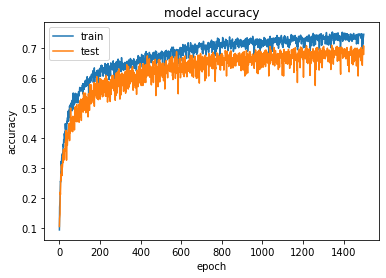

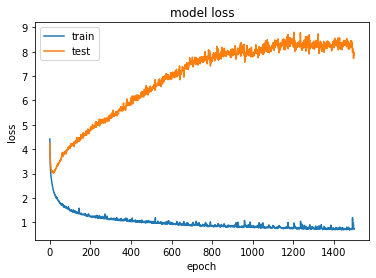

In [41]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

12/12 [==============================] - 0s 1ms/step - loss: 6.8746 - accuracy: 0.6875
Accuracy from evaluate: 68.75


In [43]:
predict_x = model.predict(X_test)
pred = np.argmax(predict_x, axis=1)
#print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

12/12 [==============================] - 0s 911us/step


In [44]:
df = pd.DataFrame()

#df["Org"] = encoder.inverse_transform(X_test)
df["Dest"] = encoder_dest.inverse_transform(argmax(yhot_test, axis=1))
df["Pred_Dest"] = encoder_dest.inverse_transform(pred)

In [45]:
df

,Dest,Pred_Dest
0,CDG,CDG
1,LYS,LYS
2,AMS,MRS
3,AMS,AMS
4,AMS,AMS
...,...,...
379,ORY,ORY
380,ORY,ORY
381,BER,BER
382,BCN,LUX


In [46]:
df[df["Dest"]==df["Pred_Dest"]]

,Dest,Pred_Dest
0,CDG,CDG
1,LYS,LYS
3,AMS,AMS
4,AMS,AMS
5,BER,BER
...,...,...
376,OSL,OSL
377,CDG,CDG
379,ORY,ORY
380,ORY,ORY


In [47]:
X_test

,0,1,2
998,34,71,52
1621,47,25,46
611,35,18,17
514,27,62,39
413,19,58,7
...,...,...,...
192,12,12,44
1730,0,6,55
433,16,55,5
570,27,62,5


In [48]:
new_test = pd.DataFrame()

In [49]:
new_test['0'] = [54]
new_test['1'] = [21]
new_test['2'] = [20]

In [50]:
new_test

,0,1,2
0,54,21,20


In [51]:
from keras import backend as K
from keras.models import model_from_json


def run(text_input):  
    K.clear_session()
    f = open("model_architecture.json",'r+')
    json_string = f.read()
    f.close()
    model = model_from_json(json_string)

    model.load_weights('model_weights.h5')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    predict_x = model.predict(text_input)
    pred = np.argmax(predict_x, axis=1)
    
    ans = encoder_dest.inverse_transform(pred)

    return ans[0]
    K.clear_session()

In [52]:
run(new_test)

1/1 [==============================] - 0s 61ms/step


'AMS'

In [ ]:
model.save_weights('model_weights.h5')
json_string = model.to_json()
f = open("model_architecture.json",'w')
f.write(json_string)
f.close()